## Load Dataset 

In [54]:
import pandas as pd 

FILENAME = "train.csv"
df = pd.read_csv(FILENAME)
df

,Year,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S80,S81,S82,S83,S84,S85,S86,S87,S88,S89
0,2007,44.76752,114.82099,3.83239,27.99928,1.49153,-15.90853,28.24844,3.61650,-7.24653,...,-1.89619,-471.02844,411.56205,443.01198,19.30254,309.07806,-336.91706,-14.70547,-474.44157,31.32820
1,2004,52.28942,75.73319,11.35941,-6.20582,-27.64559,-30.75995,12.50955,7.47877,9.88498,...,4.57060,1.36110,-6.52977,59.48672,3.69790,-36.92252,44.08077,3.39993,-70.07591,3.86143
2,2005,33.81773,-139.07371,134.19332,17.85216,63.47408,-25.28005,-34.65911,-5.99135,1.27848,...,54.16608,15.04530,39.09107,39.03041,3.68708,-61.88547,45.68115,6.39822,3.24471,35.74749
3,1998,41.60866,3.17811,-3.97174,23.53564,-19.68553,20.74407,18.80866,6.24474,-7.98424,...,28.08591,295.88684,54.02395,102.02880,40.47711,15.10258,-250.32293,2.81288,56.05172,3.60432
4,1987,44.49525,-32.25270,58.08217,3.73684,-32.53274,-18.72885,-15.85665,-3.34607,22.63786,...,31.44988,-136.50457,-85.11989,-74.96342,9.56921,-100.61689,-133.29315,9.19246,-97.37953,30.11015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252170,1993,46.19915,12.97202,29.32321,12.49879,-14.88763,-14.60964,-9.07813,-4.77650,14.45143,...,5.18055,-68.43144,-255.37766,-19.92673,-20.46062,-64.44939,-564.09909,13.39130,-126.59750,34.17522
252171,2008,45.57508,-30.83634,-9.13791,7.80413,-0.41150,-2.97301,2.22720,-15.02186,5.78416,...,-5.11588,-29.11996,43.99473,172.10433,27.92205,-25.05652,-176.00554,11.80790,-217.53687,-37.22642
252172,1979,48.18397,-19.28290,35.40170,-4.43572,-35.35641,-1.80437,-2.59621,-0.31640,-0.13533,...,12.08210,-101.94608,104.57106,56.94138,-6.47794,32.00236,-91.34596,-3.85441,63.39848,-5.69944
252173,1995,29.99863,-35.84167,58.65438,21.15740,17.93387,25.19035,-27.95186,14.64049,-10.70063,...,32.86108,-324.89056,109.56178,133.21987,-8.94126,159.61415,175.69657,7.00635,-102.02967,16.69539


## Dataset Info 

Number of duplicate rows:  52
Questa è la variabile X  

(252123, 90)


Questa è la variabile y  

(252123,)
Number of Nan Rows:  0
Number of rows:  252123
Number of columns:  91


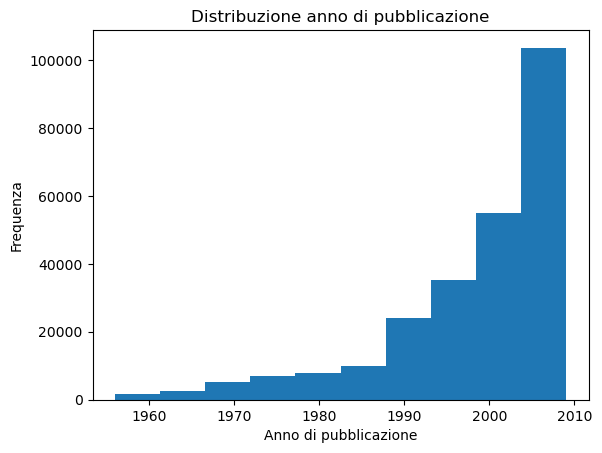

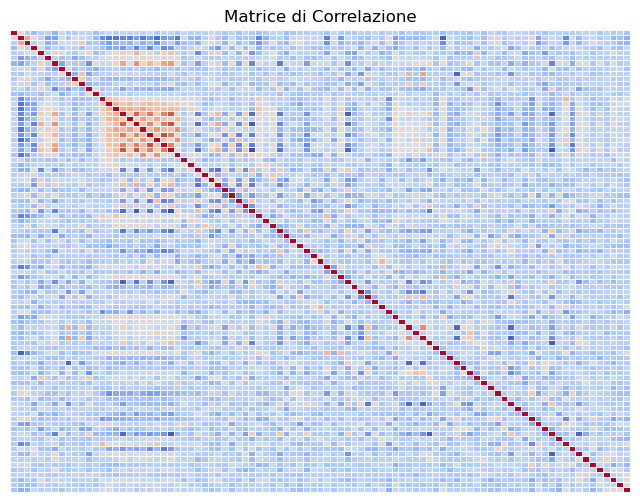

,Year,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S80,S81,S82,S83,S84,S85,S86,S87,S88,S89
Year,1.000000,0.213149,-0.001832,-0.129074,-0.003938,0.019515,-0.169174,0.095213,-0.024117,-0.027370,...,-0.030814,-0.002243,0.024368,0.037740,0.054777,-0.055590,0.025376,-0.043381,0.009868,-0.053436
S0,0.213149,1.000000,0.558754,0.248705,0.023991,-0.284982,-0.260284,0.164988,-0.057143,0.221058,...,-0.360040,0.189109,-0.136963,0.032369,0.127525,-0.024526,0.047169,-0.145372,-0.105619,-0.182971
S1,-0.001832,0.558754,1.000000,0.022646,0.132121,-0.188175,-0.101618,0.112387,0.110166,0.126423,...,-0.288081,0.051866,-0.149088,0.024786,0.147371,0.046378,-0.002788,-0.013805,-0.122098,-0.159251
S2,-0.129074,0.248705,0.022646,1.000000,0.155434,-0.132145,0.036405,-0.054220,0.081319,0.042315,...,0.068947,0.171300,0.104075,-0.006991,-0.030990,-0.090743,0.080627,-0.062984,-0.099614,0.096715
S3,-0.003938,0.023991,0.132121,0.155434,1.000000,0.034437,0.324256,0.284863,0.033020,-0.038691,...,-0.020893,-0.094068,0.045185,0.060398,-0.068541,0.043292,0.034660,0.249938,0.033186,0.011233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S85,-0.055590,-0.024526,0.046378,-0.090743,0.043292,0.006048,0.210750,-0.015940,-0.030155,0.013455,...,-0.025067,-0.133581,0.081055,0.089901,0.052687,1.000000,0.010796,0.155261,0.152704,-0.013106
S86,0.025376,0.047169,-0.002788,0.080627,0.034660,-0.005347,-0.034651,0.013615,0.013508,0.062083,...,0.047284,-0.017604,0.148040,0.333495,0.005406,0.010796,1.000000,0.011742,0.100337,0.250297
S87,-0.043381,-0.145372,-0.013805,-0.062984,0.249938,-0.017195,0.148556,0.068472,0.049102,-0.012222,...,0.076391,0.024953,0.276060,0.007675,-0.211285,0.155261,0.011742,1.000000,0.066177,0.222273
S88,0.009868,-0.105619,-0.122098,-0.099614,0.033186,0.007829,-0.020012,0.078573,0.000726,-0.006798,...,0.101466,-0.047575,0.045605,0.052842,-0.035555,0.152704,0.100337,0.066177,1.000000,0.193516


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

duplicates = df.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

df = df.drop_duplicates()


X = df.drop("Year", axis=1)
y = df["Year"]

print("Questa è la variabile X  \n")
print(X.shape)
print("\n\nQuesta è la variabile y  \n")
print(y.shape)
total_nan_rows = df.isna().any(axis=1).sum()


print("Number of Nan Rows: ", total_nan_rows)


num_rows, num_cols = df.shape
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

plt.hist(df['Year'])
plt.xlabel('Anno di pubblicazione')
plt.ylabel('Frequenza')
plt.title('Distribuzione anno di pubblicazione')
plt.show()

matrix_corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(matrix_corr, annot=False, cmap='coolwarm', fmt=".2f",linewidths=.5, xticklabels=False, yticklabels=False, cbar=False)
plt.title('Matrice di Correlazione')
plt.show()

matrix_corr


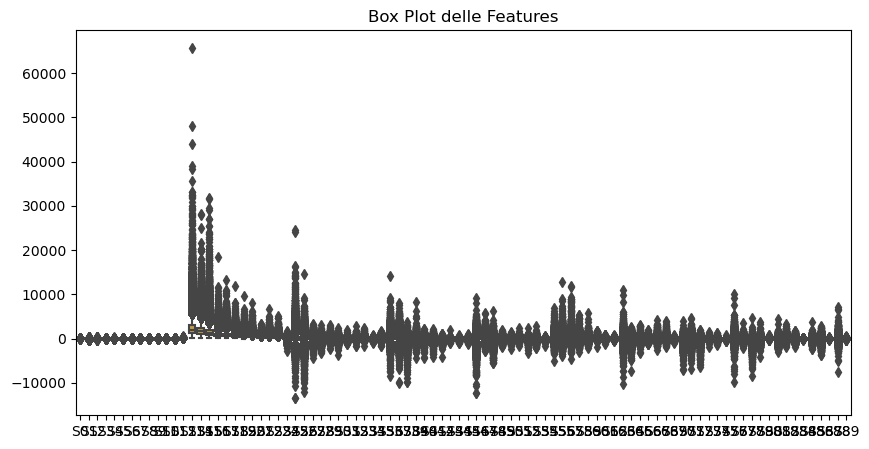

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(X)
plt.title('Box Plot delle Features')
plt.show()


## PreProcess


In [57]:
from sklearn import preprocessing
import pickle
# a function with different normalization and scaling techniques
def preprocessTrain(X_train, X_test, modality):
    
    X_train_p = X_train
    X_test_p = X_test

    if modality == 'standard':
        file = open(file="standardScaler.save", mode="wb")
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train)
        pickle.dump(obj=scaler, file=file)
        X_train_p = scaler.transform(X_train)
        X_test_p = scaler.transform(X_test)
        
    if modality == 'min-max':
        file = open(file="minMaxScaler.save", mode="wb")
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(X_train)
        pickle.dump(obj=scaler, file=file)
        X_train_p = scaler.transform(X_train)
        X_test_p = scaler.transform(X_test)
        
    return X_train_p, X_test_p



## Linear Regression

In [58]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import itertools
from scipy import stats


seed = 42


# Esegui lo split in set di addestramento, di test e di validazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

pre = ['No', 'standard', 'min-max']
hyperparameters = itertools.product(pre)

def score(model, X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

best_r2 = -np.inf
best_preprocessing = 'No'

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for preprocessing_type in pre:  # Rinomina la variabile per evitare conflitti
    # Preprocess
    X_train_p, X_val_p = preprocessTrain(X_train, X_val, preprocessing_type)
    
    # Initialize Linear Regression model
    model = LinearRegression()
    
    # Cross-validate
    scores = cross_val_score(model, X_train_p, y_train, cv=cv, scoring=score)
    
    # Save best result so far
    avg_r2 = np.mean(scores)
    print("Cross-validation R-squared: {:.3f}".format(avg_r2), "Preprocessing =", preprocessing_type)
    
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_preprocessing = preprocessing_type

print("\nBest Preprocessing:", best_preprocessing)


Cross-validation R-squared: 0.232 Preprocessing = No
Cross-validation R-squared: 0.232 Preprocessing = standard
Cross-validation R-squared: 0.232 Preprocessing = min-max

Best Preprocessing: min-max


In [59]:

# Final training and testing
X_train_p, X_test_p = preprocessTrain(X_train, X_test, "standard")
model = LinearRegression()
model.fit(X_train_p, y_train)

file = open("regression.save","wb")
pickle.dump(model, file)
file.close()

y_test_pred = model.predict(X_test_p)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = np.mean(np.abs(y_test - y_test_pred))
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Print results
print("\nTest set MSE: {:.2f}".format(mse_test))
print("Test set R-squared: {:.2f}".format(r2_test))
print("Test set MAE: {:.2f}".format(mae_test))
print("Test set MAPE: {:.2f}%".format(mape_test))


Test set MSE: 83.46
Test set R-squared: 0.23
Test set MAE: 6.60
Test set MAPE: 0.33%


## Random Forest 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing as sk_preprocessing
import numpy as np
import itertools

# Caricamento dei dati
FILENAME = "train.csv"
df = pd.read_csv(FILENAME)

# Seleziona le variabili di input (X) e output (y)
X = df.drop("Year", axis=1)
y = df["Year"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Hyperparameters
pre = ['No', 'standard', 'min-max']
hyperparameters = itertools.product(pre)

def score(model, X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

best_r2 = -np.inf
best_preprocessing = 'No'

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for preprocessing_type in pre:
    # Preprocess
    X_train_p, X_val_p = preprocessTrain(X_train, X_val, preprocessing_type)
    
    # Initialize Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=seed)  # Modifica il numero di stimatori se necessario
    
    # Cross-validate
    scores = cross_val_score(model, X_train_p, y_train, cv=cv, scoring=score)
    
    # Save best result so far
    avg_r2 = np.mean(scores)
    print("Cross-validation R-squared: {:.3f}".format(avg_r2), "Preprocessing =", preprocessing_type)
    
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_preprocessing = preprocessing_type

print("\nBest Preprocessing:", best_preprocessing)


In [ ]:

# Final training and testing
X_train_p, X_test_p = preprocessTrain(X_train, X_test, "min-max")
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Modifica il numero di stimatori se necessario
model.fit(X_train_p, y_train)

file = open("randomForestReg.save","wb")
pickle.dump(model, file)
file.close()

y_test_pred = model.predict(X_test_p)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = np.mean(np.abs(y_test - y_test_pred))
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Print results
print("\nTest set MSE: {:.2f}".format(mse_test))
print("Test set R-squared: {:.2f}".format(r2_test))
print("Test set MAE: {:.2f}".format(mae_test))
print("Test set MAPE: {:.2f}%".format(mape_test))


## SVR


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import itertools


seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

Cs = [0.01, 0.1, 1, 10, 100]
kernels = ['linear', 'poly', 'rbf']
hyperparameters = itertools.product(kernels, Cs)

def score(model, X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

best_r2 = -np.inf
best_C = 0
best_kernel = 'linear'

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for kernel, C in hyperparameters:
    # Preprocess
    X_train_p, X_val_p = preprocessTrain(X_train, X_val, "min_max")
    
    # Initialize SVR model
    model = SVR(kernel=kernel, C=C)
    
    # Cross-validate
    scores = cross_val_score(model, X_train_p, y_train, cv=cv, scoring=score)
    
    # Save best result so far
    avg_r2 = np.mean(scores)
    print("Cross-validation R-squared: {:.3f}".format(avg_r2), "Kernel =", kernel, "Preprocessing =", "min-max", "C =", C)
    
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_C = C
        best_kernel = kernel

print("\nBest C value:", best_C)
print("Best Kernel:", best_kernel)


In [ ]:

# Final training and testing
X_train_p, X_test_p = preprocessTrain(X_train, X_test, "min-max")
model = SVR(kernel=best_kernel, C=best_C)
model.fit(X_train_p, y_train)

file = open("supportVectorReg.save","wb")
pickle.dump(model, file)
file.close()

y_test_pred = model.predict(X_test_p)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = np.mean(np.abs(y_test - y_test_pred))
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Print results
print("\nTest set MSE: {:.2f}".format(mse_test))
print("Test set R-squared: {:.2f}".format(r2_test))
print("Test set MAE: {:.2f}".format(mae_test))
print("Test set MAPE: {:.2f}%".format(mape_test))


## KNN Regressor 

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing as sk_preprocessing
import numpy as np
import itertools
from scipy import stats
from sklearn.model_selection import GridSearchCV

seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

pre = ['No', 'standard', 'min-max']
n_neighbors_values = [5, 7, 9, 11]  # Modifica i valori secondo le tue esigenze
hyperparameters = list(itertools.product(pre, n_neighbors_values))

def score(model, X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

best_r2 = -np.inf
best_preprocessing = 'No'
best_n_neighbors = 0

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for preprocessing_type, n_neighbors in hyperparameters:
    # Preprocess
    X_train_p, X_val_p = preprocessTrain(X_train, X_val, preprocessing_type)
    
    # Initialize KNN Regressor model
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    # Cross-validate
    scores = cross_val_score(model, X_train_p, y_train, cv=cv, scoring=score)
    
    # Save best result so far
    avg_r2 = np.mean(scores)
    print("Cross-validation R-squared: {:.3f}".format(avg_r2), "Preprocessing =", preprocessing_type, "n_neighbors =", n_neighbors)
    
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_preprocessing = preprocessing_type
        best_n_neighbors = n_neighbors

print("\nBest Preprocessing:", best_preprocessing)
print("Best n_neighbors:", best_n_neighbors)


Cross-validation R-squared: -0.013 Preprocessing = No n_neighbors = 5
Cross-validation R-squared: 0.029 Preprocessing = No n_neighbors = 7
Cross-validation R-squared: 0.051 Preprocessing = No n_neighbors = 9
Cross-validation R-squared: 0.065 Preprocessing = No n_neighbors = 11
Cross-validation R-squared: 0.167 Preprocessing = standard n_neighbors = 5
Cross-validation R-squared: 0.199 Preprocessing = standard n_neighbors = 7
Cross-validation R-squared: 0.214 Preprocessing = standard n_neighbors = 9
Cross-validation R-squared: 0.223 Preprocessing = standard n_neighbors = 11
Cross-validation R-squared: 0.217 Preprocessing = min-max n_neighbors = 5
Cross-validation R-squared: 0.246 Preprocessing = min-max n_neighbors = 7
Cross-validation R-squared: 0.260 Preprocessing = min-max n_neighbors = 9
Cross-validation R-squared: 0.269 Preprocessing = min-max n_neighbors = 11

Best Preprocessing: min-max
Best n_neighbors: 11

Test set MSE: 78.33
Test set R-squared: 0.28
Test set MAE: 6.39
Test set 

In [62]:

X_train_p, X_test_p = preprocessTrain(X_train, X_test, "min-max")
model = KNeighborsRegressor(n_neighbors=11)
model.fit(X_train_p, y_train)

file = open("kNeighborReg.save","wb")
pickle.dump(model, file)
file.close()

y_test_pred = model.predict(X_test_p)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = np.mean(np.abs(y_test - y_test_pred))
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Print results
print("\nTest set MSE: {:.2f}".format(mse_test))
print("Test set R-squared: {:.2f}".format(r2_test))
print("Test set MAE: {:.2f}".format(mae_test))
print("Test set MAPE: {:.2f}%".format(mape_test))


Test set MSE: 78.33
Test set R-squared: 0.28
Test set MAE: 6.39
Test set MAPE: 0.32%
